In [6]:
%matplotlib inline


import numpy as np
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO
from Bio.Seq import Seq

import seaborn as sns
import matplotlib.pyplot as plt

import glob

import subprocess
from subprocess import call

import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas

import pickle

from scipy.stats import fisher_exact

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Metadata, RiboSET, PhyloSET, RiboSET_ext

In [7]:
metadata_pc_g25 = pd.read_csv('../../tmp_res/metadata_pc_g25.txt', sep='\t')
meta = pd.read_csv('../../tmp_res/local_and_global_df_g25ovlp_g35ovlp_g38ovlp_refseqovlp_strand_FRAMES_PhyloCSF.txt', sep='\t')

In [8]:
# open SET1 (PhyloSET) and SET2 (RiboSET)
PhyloSET = pd.read_csv('../../tmp_res/SET1.txt', sep='\t')

RiboSET = pd.read_csv('../../tmp_res/SET2.txt', sep='\t')
RiboSET['tr_id1'] = [x.split('.')[0] for x in RiboSET['tr_id'].tolist()]
RiboSET = RiboSET[(~RiboSET['Riboseq_Summary'].str.contains('ATG')) & 
                  (~RiboSET['tr_id'].str.contains('PAR'))]
print (RiboSET.shape[0])

390


In [9]:
!ls ../

1_Transcripts_without_upstream_initiation.ipynb
2_extended_top_5000_RiboSET.ipynb
3_localisation_prediction_SignalP_TargetP_TMHMM_Phobius.ipynb
4_Set_enrichment_and_UpsetR.ipynb
jupyters
plots
profiles
RiboSET_extended_top5000_filtered.txt
Supplementary_tables
Supplementary_tablesRiboSET_ext_loc_HPA.txt
tmp_res


In [10]:
RiboSET['strand'] = RiboSET['strand'].map({'+':'plus', '-':'minus'})

RiboSET.to_csv('../Supplementary_tables/Supplementary_table_1_RiboSET.txt', sep='\t', index=False)

PhyloSET['strand'] = PhyloSET['strand'].map({'+':'plus', '-':'minus'})

PhyloSET.to_csv('../Supplementary_tables/Supplementary_table_1_PhyloSET.txt', sep='\t', index=False)

In [11]:
RiboSET_EXT_cds_cov_nonzero = pd.read_csv('FINAL_RiboSET_EXT_cds_cov_nonzero_theor_len_20codons_3532genes.txt', 
                                  sep='\t')


print (RiboSET_EXT_cds_cov_nonzero.shape[0])

RiboSET_EXT_cds_cov_nonzero['strand'] = RiboSET_EXT_cds_cov_nonzero['strand'].map({'+':'plus', '-':'minus'})

RiboSET_EXT_cds_cov_nonzero[0:2]

3451


,tr_id1,Z_score,CDS_coverage,NTE_coverage,CDS_nonzero_fraction,NTE_nonzero_fraction,gene_ext,Start_ext,Stop_ext,global_rank_ext,...,max_sum_overlap_g38_all_exons_strandless,max_sum_overlap_refseq_all_exons,max_sum_overlap_refseq_all_exons_strandless,ovlp,ovlp_strandless,ovlp2,ovlp2_strandless,PhyloCSF120score,number_of_records,records_names
0,ENST00000379454,0.032101,298.318841,317.934783,0.332894,0.260870,ASPH,144,189,1,...,0,0,0,0;0;0,0;0;0,0;0;0;0,0;0;0;0,-1473.5792,93,Human; Chimp; Bonobo; Gorilla; Orangutan; Gibb...
1,ENST00000216281,0.139750,195.778990,441.650000,0.158709,0.194444,HSP90AA1,168,207,2,...,0,0,0,0;0;0,0;0;0,0;0;0;0,0;0;0;0,-1331.1851,63,Human; Chimp; Gorilla; Orangutan; Gibbon; Crab...


In [12]:
RiboSET_EXT_cds_cov_nonzero.to_csv('../Supplementary_tables/Supplementary_table_2_RiboSET_ext.txt', sep='\t', index=False)

# Matching set to RiboSET and RiboSET ext

In [13]:
subset = pd.read_csv('all_subset_FINAL.txt', sep='\t')
subset[0:3]

,tr_id1,Z_score,CDS_coverage,NTE_coverage,CDS_nonzero_fraction,NTE_nonzero_fraction,gene,ovlp
0,ENST00000374644,-0.360191,1.004032,0.0,0.393145,0.0,EPHA8,0;0;0
1,ENST00000360295,-0.360690,1.018109,0.0,0.303823,0.0,SEZ6,0;0;0
2,ENST00000409204,-0.598664,1.018908,0.0,0.477941,0.0,PCDH20,0;0;0


In [14]:
subset.shape[0]

384

In [15]:
subset.to_csv('../Supplementary_tables/Supplementary_table_1_UntranslSET_ext.txt', sep='\t', index=False)

# SignalP

# RiboSET

In [34]:
RiboSET['start_codon_local_coo_start'] = [int(x.split('; ')[1].split('-')[0])-1 for x in RiboSET['Riboseq_Summary'].tolist()]

riboset_fasta = open('localisation/RiboSET_theor_ext.fasta', 'w')

li = []

for row in RiboSET[['tr_id', 'gene', 'N_term_start1', 'N_term_end1', 'start_codon_local_coo_start']].to_numpy():
    tr_id  = row[0]
    gene = row[1]
    N_term_start = row[2]
    N_term_stop = row[3]
    N_term_start_pred = row[-1] 
    tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq 
    cds_stop = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_stop_pos
    cds_start = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
    
    nte_seq_nt1 = tr_seq[N_term_start:cds_stop]
    nte_seq_nt2 = tr_seq[N_term_start_pred:cds_stop]
    
    nte_seq_aa1 = str(Seq(nte_seq_nt1).translate())
    nte_seq_aa2 = 'M'+str(Seq(nte_seq_nt2).translate())[1:]
    
    # position of CDS in NTE_aa: 
    # 5'    N_term_start_pred    cds_start_pos
    # 
    
    # CDS START IN THEOR EXT
    cds_start_aa_in_ext2 = (cds_start - N_term_start) // 3
    
    li.append([tr_id, gene, nte_seq_aa1, nte_seq_aa2, cds_start_aa_in_ext2, 
              cds_start_aa_in_ext2])
    
    riboset_fasta.write('>'+tr_id+'_'+gene+'\n')
    riboset_fasta.write(nte_seq_aa1+'\n')
  
riboset_fasta.close()
        
NTE_aa_df_ribo = pd.DataFrame(li, columns = ['tr_id', 'gene', 'nte_seq_aa1', 'nte_seq_aa2',
                                       'cds_start_aa_in_ext2', 'ext_len'])


In [35]:
signalP_df_r = pd.read_csv('localisation/SignalP/RiboSET_theor_ext_SignalP.txt', sep='\t', comment='#', header=None)
signalP_df_r.columns = ['id', 'class', 'SP_score', 'Other_score', 'SP_seq']
signalP_df_r['tr_id'] = [x.split('_')[0] for x in signalP_df_r['id'].tolist()]
signalP_df_r['gene'] = [x.split('_')[-1] for x in signalP_df_r['id'].tolist()]

# exclude AUGs 
signalP_df_r = signalP_df_r[~signalP_df_r['gene'].isin(['STIM2', 'AP3S1', 'PTPRJ'])]

tmp = signalP_df_r[(signalP_df_r['class'] != 'OTHER') & (signalP_df_r['SP_seq'] != 'CS pos: ?. Probable protein fragment')]
tmp['SP_end_pos'] = [int(x.split('CS pos: ')[1].split('-')[0]) for x in tmp['SP_seq'].tolist()]
tmp = tmp.merge(NTE_aa_df_ribo[['tr_id', 'gene', 'cds_start_aa_in_ext2']], on=['tr_id', 'gene'], how='inner')
tmp['SP_start_pos'] = tmp['SP_end_pos'] - 16

### genes with CS-16 position before CDS 
print (', '.join(tmp[tmp['cds_start_aa_in_ext2'] >= tmp['SP_start_pos']]['gene'].tolist()))

len(tmp[tmp['cds_start_aa_in_ext2'] >= tmp['SP_start_pos']]['gene'].tolist())

ADAM15, CRIPT, TSN, ZNF622, GINS4, POLR1E, TCF7L2, ZIC2, SUPT4H1, RAE1


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


10

In [19]:
tmp[tmp['cds_start_aa_in_ext2'] >= tmp['SP_start_pos']].to_csv('../Supplementary_tables/RiboSET_SignalP.txt', sep='\t', index=False)

In [ ]:
tmp[tmp['cds_start_aa_in_ext2'] >= tmp['SP_start_pos']]

In [36]:
tmp[tmp['SP_end_pos'] <= tmp['cds_start_aa_in_ext2']]

,id,class,SP_score,Other_score,SP_seq,tr_id,gene,SP_end_pos,cds_start_aa_in_ext2,SP_start_pos
1,ENST00000238892.3_CRIPT,SP(Sec/SPI),0.992859,0.007141,CS pos: 30-31. SWG-RM. Pr: 0.7394,ENST00000238892.3,CRIPT,30,31,14
2,ENST00000389682.7_TSN,SP(Sec/SPI),0.728701,0.271299,CS pos: 18-19. TLA-DC. Pr: 0.2152,ENST00000389682.7,TSN,18,25,2
5,ENST00000276533.3_GINS4,SP(Sec/SPI),0.753739,0.246261,CS pos: 19-20. SWC-PD. Pr: 0.3796,ENST00000276533.3,GINS4,19,51,3
6,ENST00000377798.8_POLR1E,SP(Sec/SPI),0.519883,0.480117,CS pos: 32-33. VLG-GQ. Pr: 0.3510,ENST00000377798.8,POLR1E,32,37,16
7,ENST00000369397.8_TCF7L2,SP(Sec/SPI),0.729950,0.270050,CS pos: 20-21. ILG-NE. Pr: 0.6721,ENST00000369397.8,TCF7L2,20,101,4
8,ENST00000376335.7_ZIC2,SP(Sec/SPI),0.501424,0.498576,CS pos: 32-33. LRA-RP. Pr: 0.1709,ENST00000376335.7,ZIC2,32,97,16
10,ENST00000395841.6_RAE1,SP(Sec/SPI),0.974323,0.025677,CS pos: 21-22. ARA-GS. Pr: 0.7476,ENST00000395841.6,RAE1,21,45,5


# PhyloSET 

In [21]:
li = []

f = open('localisation/PhyloSET_theor_ext.fasta', 'w')

for row in PhyloSET[['tr_id', 'gene', 'N_term_start1', 'N_term_end1']].to_numpy():
    tr_id  = row[0]
    gene = row[1]
    N_term_start = row[2]
    N_term_stop = row[3]
    tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq 
    cds_stop = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_stop_pos
    cds_start = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
    
    nte_seq_nt1 = tr_seq[N_term_start:cds_stop]
    
    nte_seq_aa1 = str(Seq(nte_seq_nt1).translate())
    
    # position of CDS in NTE_aa: 
    # 5'    N_term_start_pred    cds_start_pos
    # 
    cds_start_aa_in_ext2 = (cds_start - N_term_start) // 3
    
    li.append([tr_id, gene, nte_seq_aa1, cds_start_aa_in_ext2])
    
    f.write('>'+tr_id+'_'+gene+'\n')
    f.write(nte_seq_aa1[:-1]+'\n')
    
NTE_aa_df = pd.DataFrame(li, columns = ['tr_id', 'gene', 'nte_seq_aa1', 
                                       'cds_start_aa_in_ext2'])

f.close()

In [22]:
signalP_df = pd.read_csv('localisation/SignalP/PhyloSET_SignalP.txt', sep='\t', comment='#', header=None)
signalP_df.columns = ['id', 'class', 'SP_score', 'Other_score', 'SP_seq']
signalP_df['tr_id'] = [x.split('_')[0] for x in signalP_df['id'].tolist()]
signalP_df['gene'] = [x.split('_')[-1] for x in signalP_df['id'].tolist()]

print ('# of genes with pred signalP from PhyloSET')
signalP_df[(signalP_df['class'] != 'OTHER') & 
           (signalP_df['SP_seq'] != 'CS pos: ?. Probable protein fragment')].shape[0]

# of genes with pred signalP from PhyloSET


0

In [23]:
d = {'RiboSET': 10, # 1
 'PhyloSET': 0, 
 'RiboSET_ext': 0,
 'UntranslSET': 0,
 'UtranslSET_ext': 0,

}

# RiboSET-match 

In [27]:
b = subset[['tr_id1']].merge(meta, on=['tr_id1'], how='inner')

b.shape

(384, 30)

In [28]:
match_fasta = open('localisation/Match_theor_ext.fasta', 'w')

li = []

for row in b[['tr_id', 'gene', 'N_term_start1', 'N_term_end1']].to_numpy():
    tr_id  = row[0]
    gene = row[1]
    N_term_start = row[2]
    N_term_stop = row[3]
    
    tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq 
    cds_stop = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_stop_pos
    cds_start = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
    
    nte_seq_nt1 = tr_seq[N_term_start:cds_stop]  
    nte_seq_aa1 = str(Seq(nte_seq_nt1).translate())
    
    cds_start_aa_in_ext2 = (cds_start - N_term_start) // 3
    
    li.append([tr_id, gene, nte_seq_aa1, cds_start_aa_in_ext2])
    
    match_fasta.write('>'+tr_id+'_'+gene+'\n')
    match_fasta.write(nte_seq_aa1+'\n')
  
match_fasta.close()
        
match_aa_df = pd.DataFrame(li, columns = ['tr_id', 'gene', 'nte_seq_aa1', 
                                       'cds_start_aa_in_ext2'])


In [29]:
!grep '>' localisation/Match_theor_ext.fasta | wc -l

384


In [30]:
signalP_df_m = pd.read_csv('localisation/SignalP/Match_SignalP_384.txt', sep='\t', comment='#', header=None)

print (signalP_df_m.shape[0])

signalP_df_m.columns = ['id', 'class', 'SP_score', 'Other_score', 'SP_seq']
signalP_df_m['tr_id'] = [x.split('_')[0] for x in signalP_df_m['id'].tolist()]
signalP_df_m['gene'] = [x.split('_')[-1] for x in signalP_df_m['id'].tolist()]

tmp = signalP_df_m[(signalP_df_m['class'] != 'OTHER') & 
                   (signalP_df_m['SP_seq'].notna())]
tmp['SP_end_pos'] = [int(x.split('CS pos: ')[1].split('-')[0]) for x in tmp['SP_seq'].tolist()]
tmp = tmp.merge(match_aa_df[['tr_id', 'gene', 'cds_start_aa_in_ext2']], on=['tr_id', 'gene'], how='inner')
tmp['SP_start_pos'] = tmp['SP_end_pos'] - 16


### genes with CS-16 position before CDS 
tmp[tmp['cds_start_aa_in_ext2'] >= tmp['SP_start_pos']]['gene'].tolist()

384


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


['PCMTD1', 'ZNF766', 'SLC12A4', 'GTPBP3', 'NEDD4L']

In [24]:
d = {'RiboSET': 10, # 1
 'PhyloSET': 0, 
 'UntranslSET': 5,    
 'RiboSET_ext': 0,

}

In [25]:
# RiboSET vs untransl
a = 10
b = 390-10
c = 5
d = 384-5


table  = [[a, b],  [c, d]] 

oddsr, p = fisher_exact(table, alternative='greater')

p, oddsr

(0.15569569862353697, 1.9947368421052631)

In [26]:
meta[(meta['tr_id'].isin(tmp[tmp['cds_start_aa_in_ext2'] >= tmp['SP_start_pos']]['tr_id'].tolist()))]

,tr_id,N_term_start,N_term_end,len,N_term_start1,N_term_end1,len_codons,gene,50len_flag,global_coo_50_and_less,...,max_sum_overlap_refseq_all_exons,max_sum_overlap_refseq_all_exons_strandless,ovlp,ovlp_strandless,ovlp2,ovlp2_strandless,PhyloCSF120score,tr_id1,number_of_records,records_names
31007,ENST00000544451.2,0,75,75,0,75,25.0,PCMTD1,0,chr8:51899112-51899186,...,0,0,0;0;0,0;0;0,0;0;0;0,0;0;0;0,-1466.7897,ENST00000544451,88,Human; Chimp; Bonobo; Gorilla; Orangutan; Gibb...
57227,ENST00000541864.6,0,104,104,2,104,34.0,SLC12A4,2,chr16:67966775-67966876,...,0,0,0;0;0,0;0;0,0;0;0;0,0;0;0;0,-1974.2952,ENST00000541864,115,Human; Chimp; Bonobo; Gorilla; Orangutan; Gibb...
64364,ENST00000635997.1,138,201,63,138,201,21.0,NEDD4L,138,chr18:58255578-58255640,...,0,0,0;0;0,0;0;0,0;0;0;0,0;0;0;0,-534.4848,ENST00000635997,118,Human; Chimp; Bonobo; Gorilla; Gibbon; Rhesus;...
66536,ENST00000361619.9,0,84,84,0,84,28.0,GTPBP3,0,chr19:17334920-17335003,...,0,0,0;0;0,0;0;0,0;0;0;0,0;0;0;0,-1414.1394,ENST00000361619,107,Human; Chimp; Bonobo; Gorilla; Orangutan; Gibb...
69602,ENST00000600821.5,133,235,102,133,235,34.0,ZNF766,133,chr19:52274595-52274669+chr19:52275578-52275604,...,0,0,0;0;0,0;0;0,0;0;0;0,0;0;0;0,-105.2288,ENST00000600821,21,Human; Chimp; Bonobo; Gorilla; Orangutan; Gibb...


# RiboSET_EXT

In [37]:
RiboSET_EXT_cds_cov_nonzero['start_codon_local_coo_start'] = [int(x.split('; ')[1].split('-')[0])-1 for x in RiboSET_EXT_cds_cov_nonzero['Riboseq_Summary'].tolist()]

riboset_fasta = open('localisation/RiboSET_EXT_theor_ext.fasta', 'w')

li = []

for row in RiboSET_EXT_cds_cov_nonzero[['tr_id', 'gene', 'N_term_start1', 'N_term_end1', 'start_codon_local_coo_start']].to_numpy():
    tr_id  = row[0]
    gene = row[1]
    N_term_start = row[2]
    N_term_stop = row[3]
    N_term_start_pred = row[-1] 
    tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq 
    cds_stop = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_stop_pos
    cds_start = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
    
    nte_seq_nt1 = tr_seq[N_term_start:cds_stop]
    nte_seq_nt2 = tr_seq[N_term_start_pred:cds_stop]
    
    nte_seq_aa1 = str(Seq(nte_seq_nt1).translate())
    nte_seq_aa2 = 'M'+str(Seq(nte_seq_nt2).translate())[1:]
    
    # position of CDS in NTE_aa: 
    # 5'    N_term_start_pred    cds_start_pos
    # 
    cds_start_aa_in_ext2 = (cds_start - N_term_start) // 3
    
    li.append([tr_id, gene, nte_seq_aa1, nte_seq_aa2, cds_start_aa_in_ext2, 
              cds_start_aa_in_ext2])
    
    riboset_fasta.write('>'+tr_id+'_'+gene+'\n')
    riboset_fasta.write(nte_seq_aa1+'\n')
  
riboset_fasta.close()
        
RiboSET_Ext = pd.DataFrame(li, columns = ['tr_id', 'gene', 'nte_seq_aa1', 'nte_seq_aa2',
                                       'cds_start_aa_in_ext2', 'ext_len'])


In [38]:
!grep '>' localisation/RiboSET_EXT_theor_ext.fasta | wc -l

3451


In [40]:
signalP_df_m = pd.read_csv('localisation/SignalP/EXT_SignalP.txt', sep='\t', comment='#', header=None)

print (signalP_df_m.shape[0])

signalP_df_m.columns = ['id', 'class', 'SP_score', 'Other_score', 'SP_seq']
signalP_df_m['tr_id'] = [x.split('_')[0] for x in signalP_df_m['id'].tolist()]
signalP_df_m['gene'] = [x.split('_')[-1] for x in signalP_df_m['id'].tolist()]

tmp = signalP_df_m[(signalP_df_m['class'] != 'OTHER') & 
                   (signalP_df_m['SP_seq'].notna())]


tmp['SP_end_pos'] = [int(x.split('CS pos: ')[1].split('-')[0]) for x in tmp['SP_seq'].tolist()]
tmp = tmp.merge(RiboSET_Ext[['tr_id', 'gene', 'cds_start_aa_in_ext2']], on=['tr_id', 'gene'], how='inner')
tmp['SP_start_pos'] = tmp['SP_end_pos'] - 16
tmp[0:2]

3451


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,id,class,SP_score,Other_score,SP_seq,tr_id,gene,SP_end_pos,cds_start_aa_in_ext2,SP_start_pos
0,ENST00000225504.7_SUPT4H1,SP(Sec/SPI),0.723744,0.276256,CS pos: 24-25. KMA-LE. Pr: 0.3777,ENST00000225504.7,SUPT4H1,24,22,8
1,ENST00000395841.6_RAE1,SP(Sec/SPI),0.974323,0.025677,CS pos: 21-22. ARA-GS. Pr: 0.7476,ENST00000395841.6,RAE1,21,45,5


In [41]:
tmp[tmp['cds_start_aa_in_ext2'] >= tmp['SP_start_pos']].to_csv('../Supplementary_tables/RiboSET_ext_SignalP.txt', sep='\t', index=False)

In [45]:
tmp[tmp['cds_start_aa_in_ext2'] >= tmp['SP_start_pos']].id.nunique()

53

In [47]:
tmp[tmp['SP_end_pos'] <= tmp['cds_start_aa_in_ext2']].id.nunique()

44

In [30]:
### genes with CS-16 position before CDS 
len(tmp[tmp['cds_start_aa_in_ext2'] >= tmp['SP_start_pos']]['gene'].tolist())

53

In [31]:
d = {'RiboSET': 10, # 1
 'PhyloSET': 0, 
 'UntranslSET': 7, 
     
 'RiboSET_ext': 53,
}

In [32]:
# RiboSET vs untransl
a = 53
b = 3451-53
c = 5
d = 384-5


table  = [[a, b],  [c, d]] 

oddsr, p = fisher_exact(table, alternative='greater')

p, oddsr

(0.46904685626698095, 1.1822836962919365)

# TargetP

# RiboSET

In [51]:
targetP_riboset = pd.read_csv('localisation/TargetP/RiboSET_theor_ext_TargetP.txt', sep='\t', comment='#', header=None)
targetP_riboset.columns = ['ids', 'class', 'score_other', 'score_sp', 'score_m', 'seq_m']

targetP_riboset['tr_id'] = [x.split('_')[0] for x in targetP_riboset['ids'].tolist()]
targetP_riboset['gene'] = [x.split('_')[-1] for x in targetP_riboset['ids'].tolist()]

targetP_riboset = targetP_riboset[~targetP_riboset['gene'].isin(['STIM2', 'AP3S1', 'PTPRJ'])]

print ('genes from RiboSET with mito signal: ')
print (targetP_riboset[(targetP_riboset['seq_m'].notna()) & (targetP_riboset['class'] == 'mTP')].gene.nunique())

tmp = targetP_riboset[(targetP_riboset['seq_m'].notna()) & 
                      (targetP_riboset['class'] == 'mTP')].merge(NTE_aa_df_ribo, on=['gene', 'tr_id'], how='inner')

print (tmp.shape[0])

tmp['CS_pos'] = [int(x.split('CS pos:')[1].split('-')[0]) for x in tmp['seq_m'].tolist()]
tmp['m_start'] = tmp['CS_pos']-20

len(tmp[tmp['cds_start_aa_in_ext2'] >= tmp['m_start']][['ids', 'gene', 'seq_m', 'cds_start_aa_in_ext2', 'CS_pos']].merge(NTE_aa_df_ribo, on='gene', how='left').gene.tolist())

genes from RiboSET with mito signal: 
21
21


18

In [49]:
TP = {'RiboSET': 18, # 1
 'PhyloSET': 0, 
 'RiboSET_ext': 0,
 'UntranslSET': 0,
 'UtranslSET_ext': 0,

}

In [54]:
tmp[tmp['CS_pos'] <= tmp['cds_start_aa_in_ext2']].ids.nunique()

12

In [56]:
tmp[tmp['cds_start_aa_in_ext2'] >= tmp['m_start']][['ids', 'gene', 'seq_m', 'cds_start_aa_in_ext2', 'CS_pos']].merge(NTE_aa_df_ribo, on='gene', how='left').to_csv('../Supplementary_tables/RiboSET_TargetP.txt', sep='\t', index=False)

# PhyloSET

In [57]:
targetP_phyloset = pd.read_csv('localisation/TargetP/PhyloSET_TargetP.txt', sep='\t', comment='#', header=None)
targetP_phyloset.columns = ['ids', 'class', 'score_other', 'score_sp', 'score_m', 'seq_m']

targetP_phyloset['tr_id'] = [x.split('_')[0] for x in targetP_phyloset['ids'].tolist()]
targetP_phyloset['gene'] = [x.split('_')[-1] for x in targetP_phyloset['ids'].tolist()]

print ('genes from RiboSET with mito signal: ')

print (targetP_phyloset[(targetP_phyloset['seq_m'].notna()) & (targetP_phyloset['class'] == 'mTP')].gene.nunique())

genes from RiboSET with mito signal: 
0


In [58]:
TP = {'RiboSET': 18, # 1
 'PhyloSET': 0, 
 'RiboSET_ext': 0,
 'UntranslSET': 0,
 'UtranslSET_ext': 0,

}

# RiboSET-match 

In [ ]:
targetP_riboset = pd.read_csv('localisation/TargetP/Match_384_TargetP.txt', sep='\t', comment='#', header=None)
targetP_riboset.columns = ['ids', 'class', 'score_other', 'score_sp', 'score_m', 'seq_m']

targetP_riboset['tr_id'] = [x.split('_')[0] for x in targetP_riboset['ids'].tolist()]
targetP_riboset['gene'] = [x.split('_')[-1] for x in targetP_riboset['ids'].tolist()]

targetP_riboset = targetP_riboset[~targetP_riboset['gene'].isin(['STIM2', 'AP3S1', 'PTPRJ'])]

print ('genes from RiboSET with mito signal: ')
print (targetP_riboset[(targetP_riboset['seq_m'].notna()) & (targetP_riboset['class'] == 'mTP')].gene.nunique())

tmp = targetP_riboset[(targetP_riboset['seq_m'].notna()) & 
                      (targetP_riboset['class'] == 'mTP')].merge(match_aa_df, on=['gene', 'tr_id'], how='inner')

print (tmp.shape[0])

tmp['CS_pos'] = [int(x.split('CS pos:')[1].split('-')[0]) for x in tmp['seq_m'].tolist()]
tmp['m_start'] = tmp['CS_pos']-20

In [ ]:
len(tmp[tmp['cds_start_aa_in_ext2'] >= tmp['m_start']][['ids', 'gene', 'seq_m', 'cds_start_aa_in_ext2', 'CS_pos']].merge(match_aa_df, on='gene', how='left').gene.tolist())

In [ ]:
TP = {'RiboSET': 18, # 1
 'PhyloSET': 0, 
 'UntranslSET': 7,
  'RiboSET_ext': 0,
 'UtranslSET_ext': 0,x

}

# RiboSET ext

In [59]:
targetP_riboset = pd.read_csv('localisation/TargetP/RiboSET_ext_TargetP.txt', sep='\t', comment='#', header=None)
targetP_riboset.columns = ['ids', 'class', 'score_other', 'score_sp', 'score_m', 'seq_m']

targetP_riboset['tr_id'] = [x.split('_')[0] for x in targetP_riboset['ids'].tolist()]
targetP_riboset['gene'] = [x.split('_')[-1] for x in targetP_riboset['ids'].tolist()]

targetP_riboset = targetP_riboset[~targetP_riboset['gene'].isin(['STIM2', 'AP3S1', 'PTPRJ'])]

print ('genes from RiboSET with mito signal: ')
print (targetP_riboset[(targetP_riboset['seq_m'].notna()) & (targetP_riboset['class'] == 'mTP')].gene.nunique())

tmp = targetP_riboset[(targetP_riboset['seq_m'].notna()) & 
                      (targetP_riboset['class'] == 'mTP')].merge(RiboSET_Ext, on=['gene', 'tr_id'], how='inner')

print (tmp.shape[0])

tmp['CS_pos'] = [int(x.split('CS pos:')[1].split('-')[0]) for x in tmp['seq_m'].tolist()]
tmp['m_start'] = tmp['CS_pos']-20

genes from RiboSET with mito signal: 
103
103


In [60]:
len(tmp[tmp['cds_start_aa_in_ext2'] >= tmp['m_start']][['ids', 'gene', 'seq_m', 'cds_start_aa_in_ext2', 'CS_pos']].merge(match_aa_df, on='gene', how='left').gene.tolist())

83

In [61]:
TP = {'RiboSET': 18, # 1
 'PhyloSET': 0, 
 'UntranslSET': 7,
  'RiboSET_ext': 83,
}

In [69]:
tmp[tmp['cds_start_aa_in_ext2'] >= tmp['m_start']].to_csv('../Supplementary_tables/RiboSET_ext_TargetP.txt', sep='\t', index=False)

In [70]:
tmp[tmp['cds_start_aa_in_ext2'] >= tmp['m_start']].ids.nunique()

83

In [71]:
tmp[tmp['CS_pos'] <= tmp['cds_start_aa_in_ext2']].ids.nunique()

57

In [ ]:
# RiboSET ext vs matched 
a = 18
b = 390-18
c = 7
d = 384-7


table = [[a,b], 
         [c,d]]


oddsr, p = fisher_exact(table, alternative='greater')

p, oddsr

In [ ]:
RiboSET_EXT_cds_cov_nonzero.shape[0]

In [ ]:
# RiboSET ext vs matched 
a = 83
b = 3451 - 83
c = 7
d = 384-7


table = [[a,b], 
         [c,d]]


oddsr, p = fisher_exact(table, alternative='greater')

p, oddsr

# TMHMM

# RiboSET

In [72]:
li = []

for record in SeqIO.parse("localisation/TMHMM/RiboSET_DeepTMHMM.3line", "fasta"):
    length = len(str(record.seq).split('*')[0])
    tr_id = record.id.split('_')[0]
    gene = record.id.split('_')[1]
    length = int(len(str(record.seq))/2)
    pred_seq = str(record.seq)[int(len(str(record.seq))/2):]
    real_seq = str(record.seq)[0:int(len(str(record.seq))/2)]
    real_len = len(real_seq)
    pred_len = len(pred_seq)
    
    if ('M' in list(pred_seq)):
        any_m = True 
        pos_of_1st_m = pred_seq.find('M')
    else:
        any_m = False 
        pos_of_1st_m = None
        
        
    li.append([tr_id, gene, length, real_seq, pred_seq,
                              real_len, pred_len, any_m, pos_of_1st_m])
    
    
    
parse_df = pd.DataFrame(li, columns = ['tr_id', 'gene', 'length', 'real_seq', 'prediction_seq',
                              'real_len', 'pred_len', 'any_m', 'pos_of_1st_m'])

parse_df[0:3]

,tr_id,gene,length,real_seq,prediction_seq,real_len,pred_len,any_m,pos_of_1st_m
0,ENST00000379389.4,ISG15,216,AGSAARPLTCVPQAYNRAGAACRSRRLRGSELIFASTGACAVAHSP...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,216,216,False,NaN
1,ENST00000349431.10,UBE2J2,324,AGSAPRAAILEAEAAAAALRRVRWAQSRGGAAVSGAGPAFPHPAPA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,324,324,True,296.0
2,ENST00000338370.7,AURKAIP1,333,RSGLGRVSGRPEGAGRCGRRARGPAERVRAPGNAIRAGVNPGRGPA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,333,333,False,NaN


In [73]:
TMHMM_riboset_preds = NTE_aa_df_ribo[['tr_id', 'gene', 'cds_start_aa_in_ext2']].merge(parse_df[parse_df['any_m'] == True], on=['gene'], how='inner').drop_duplicates()

TMHMM_riboset_preds[TMHMM_riboset_preds['pos_of_1st_m'] < TMHMM_riboset_preds['cds_start_aa_in_ext2']].gene.unique()

array(['CDC42SE2', 'KDSR'], dtype=object)

In [35]:
TMHMM_riboset_preds[TMHMM_riboset_preds['pos_of_1st_m'] < TMHMM_riboset_preds['cds_start_aa_in_ext2']].gene.nunique()

2

In [74]:
TMHMM_riboset_preds[TMHMM_riboset_preds['pos_of_1st_m'] < TMHMM_riboset_preds['cds_start_aa_in_ext2']].to_csv('../Supplementary_tables/RiboSET_ext_DeepTMHMM.txt', sep='\t', index=False)

In [36]:
TP = {'RiboSET': 2, # 1
 'PhyloSET': 0, 
 'RiboSET_ext': 0,
 'UntranslSET': 0,
 'UtranslSET_ext': 0,

}

# PhyloSET 

In [75]:
li = []

for record in SeqIO.parse("localisation/TMHMM/PhyloSET_DeepTHMMM.3line", "fasta"):
    tr_id = record.id.split('_')[0]
    gene = record.id.split('_')[1]
    length = int(len(str(record.seq))/2)
    pred_seq = str(record.seq)[int(len(str(record.seq))/2):]
    real_seq = str(record.seq)[0:int(len(str(record.seq))/2)]
    real_len = len(real_seq)
    pred_len = len(pred_seq)
    
    if ('M' in list(pred_seq)):
        any_m = True 
        pos_of_1st_m = pred_seq.find('M')
    else:
        any_m = False 
        pos_of_1st_m = None
        
        
    li.append([tr_id, gene, length, real_seq, pred_seq,
                              real_len, pred_len, any_m, pos_of_1st_m])
    
    
    
parse_df = pd.DataFrame(li, columns = ['tr_id', 'gene', 'length', 'real_seq', 'prediction_seq',
                              'real_len', 'pred_len', 'any_m', 'pos_of_1st_m'])

parse_df[0:3]

,tr_id,gene,length,real_seq,prediction_seq,real_len,pred_len,any_m,pos_of_1st_m
0,ENST00000377898.3,HES3,207,GTEPAARGSLPGNFRKISKPLMEKKRRARINVSLEQLKSLLEKHYS...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,207,207,False,NaN
1,ENST00000400907.6,RERE,608,KPRLTVYLSRRPSRERTEEGTWRIMTADKDKDKDKEKDRDRDRDRE...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,608,608,False,NaN
2,ENST00000455833.6,IFFO2,635,QKGQCRPRVLCVRLPRPLHSVSDSPGGETRDPSGPAQIPRPPPRPE...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,635,635,False,NaN


In [76]:
TMHMM_phyloset_preds = NTE_aa_df[['tr_id', 'gene', 'cds_start_aa_in_ext2']].merge(parse_df[parse_df['any_m'] == True], on=['gene'], how='inner').drop_duplicates()

TMHMM_phyloset_preds[TMHMM_phyloset_preds['pos_of_1st_m'] < TMHMM_phyloset_preds['cds_start_aa_in_ext2']].gene.unique()

array(['C1QL2', 'C1QL3'], dtype=object)

In [77]:
TMHMM_phyloset_preds[TMHMM_phyloset_preds['pos_of_1st_m'] < TMHMM_phyloset_preds['cds_start_aa_in_ext2']].to_csv('../Supplementary_tables/PhyloSET_ext_DeepTMHMM.txt', sep='\t', index=False)

In [39]:
TP = {'RiboSET': 2, # 1
 'PhyloSET': 0, 
 'RiboSET_ext': 0,
 'UntranslSET': 0,
 'UtranslSET_ext': 0,

}

In [40]:
TMHMM_phyloset_preds[0:2]

,tr_id_x,gene,cds_start_aa_in_ext2,tr_id_y,length,real_seq,prediction_seq,real_len,pred_len,any_m,pos_of_1st_m
0,ENST00000368061.2,VANGL2,114,ENST00000368061.2,635,PDSRTPPSTSPIARAACPGAPSSERPGALRIQRRRAERGARGAHPA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,635,635,True,220.0
1,ENST00000636345.1,NRXN1,38,ENST00000636345.1,181,SQGALLSPVLISEDGLNFLGFPLRIKKKALSTQGSQTDMDMRWHCE...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,181,181,True,105.0


In [41]:
[0:2]

,tr_id_x,gene,cds_start_aa_in_ext2,tr_id_y,length,real_seq,prediction_seq,real_len,pred_len,any_m,pos_of_1st_m
0,ENST00000349431.10,UBE2J2,64,ENST00000349431.10,324,AGSAPRAAILEAEAAAAALRRVRWAQSRGGAAVSGAGPAFPHPAPA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,324,324,True,296.0
1,ENST00000521580.2,SMIM12,48,ENST00000521580.2,141,CAPREPAASGQGHRARSRGPLGAATSVLPASGRRAGAALGSVGWAA...,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,141,141,True,60.0


# PLOT THEM 

In [61]:
tmp = pd.concat([TMHMM_phyloset_preds[TMHMM_phyloset_preds['pos_of_1st_m'] < TMHMM_phyloset_preds['cds_start_aa_in_ext2']],
                

tmp = tmp[tmp['tr_id_x'].isin(['ENST00000272520.3', 
                        'ENST00000619991.1', 
                        'ENST00000505065.1', 
                        'ENST00000406396.7'])][['tr_id_x', 'gene', 'prediction_seq', 'pos_of_1st_m', 
                                                'cds_start_aa_in_ext2']]

tmp

,tr_id_x,gene,prediction_seq,pos_of_1st_m,cds_start_aa_in_ext2
2,ENST00000272520.3,C1QL2,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,56.0,65
17,ENST00000619991.1,C1QL3,IIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMMOOOOOOO...,16.0,26
22,ENST00000505065.1,CDC42SE2,SSSSSSSSSSSSSSOOOOOOOOOMMMMMMMMMMMMMMMMMMMIIII...,23.0,37
59,ENST00000406396.7,KDSR,OOOOOOOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMM...,26.0,28


In [71]:
tmp = TMHMM_phyloset_preds[(TMHMM_phyloset_preds['pos_of_1st_m'] < TMHMM_phyloset_preds['cds_start_aa_in_ext2']) & 
                          (TMHMM_phyloset_preds['tr_id_x'].isin(['ENST00000272520.3', 
                        'ENST00000619991.1', 
                        'ENST00000505065.1', 
                        'ENST00000406396.7']))]

tmp2 = TMHMM_riboset_preds[TMHMM_riboset_preds['pos_of_1st_m'] < TMHMM_riboset_preds['cds_start_aa_in_ext2']]

tmp

,tr_id_x,gene,cds_start_aa_in_ext2,tr_id_y,length,real_seq,prediction_seq,real_len,pred_len,any_m,pos_of_1st_m
2,ENST00000272520.3,C1QL2,65,ENST00000272520.3,352,PGLGVATSGARPGPAEPVPERGERGRPRRPTITSPGGKEELVAVAS...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,352,352,True,56.0
17,ENST00000619991.1,C1QL3,26,ENST00000619991.1,239,QEDRPALSRLVGSRRRLIAAGALGVVMVLLLVILIPVLVSSAGTSA...,IIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMMOOOOOOO...,239,239,True,16.0


In [72]:
tmp2

,tr_id_x,gene,cds_start_aa_in_ext2,tr_id_y,length,real_seq,prediction_seq,real_len,pred_len,any_m,pos_of_1st_m
22,ENST00000505065.1,CDC42SE2,37,ENST00000505065.1,122,NFILASLDIIVLRSVFLELPELRFGTFIGAHLLWTVSMSEFWLCFN...,SSSSSSSSSSSSSSOOOOOOOOOMMMMMMMMMMMMMMMMMMMIIII...,122,122,True,23.0
59,ENST00000406396.7,KDSR,28,ENST00000406396.7,361,FSPRRSPALRALPGGPRPAAPGPWPRGAMLLLAAAFLVAFVLLLYM...,OOOOOOOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMM...,361,361,True,26.0


In [77]:
# add coo from PhyloSET

coordinates = {}

for row in tmp[['tr_id_x', 'gene', 'prediction_seq']].to_numpy():
    gene = row[1]
    seq = row[2]
    tr_id = row[0]
    
    cds_pos = NTE_aa_df[NTE_aa_df['tr_id'] == tr_id].iloc[0].cds_start_aa_in_ext2
    
    coordinates[gene+'_'+str(cds_pos)] = []
    
    print (gene, seq)
    
    i = 0
    
    for elem in ["".join(grp) for num, grp in itertools.groupby(seq)]:
        block = []
        block.append(elem[0])
        block.append(i)
        i = i+len(elem)
        block.append(i)
        coordinates[gene+'_'+str(cds_pos)].append(block) 
    
        
        
# add coo from RiboSET 

for row in tmp2[['gene', 'prediction_seq']].to_numpy():
    gene = row[0]
    seq = row[1]
    
    # add cds_coo 
    cds_pos = NTE_aa_df_ribo[NTE_aa_df_ribo['gene'] == gene].iloc[0].ext_len
    
    coordinates[gene+'_'+str(cds_pos)] = []
    
    
    i = 0
    
    for elem in ["".join(grp) for num, grp in itertools.groupby(seq)]:
        block = []
        block.append(elem[0])
        block.append(i)
        i = i+len(elem)
        block.append(i)
        
        coordinates[gene+'_'+str(cds_pos)].append(block)  
        
    
        
coordinates

C1QL2 IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
C1QL3 IIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO


{'C1QL2_65': [['I', 0, 56], ['M', 56, 77], ['O', 77, 352]],
 'C1QL3_26': [['I', 0, 16], ['M', 16, 39], ['O', 39, 239]],
 'CDC42SE2_37': [['S', 0, 14], ['O', 14, 23], ['M', 23, 42], ['I', 42, 122]],
 'KDSR_28': [['O', 0, 26], ['M', 26, 47], ['I', 47, 361]]}

In [99]:
coordinates = {'C1QL2_65': [['I', 0, 56], ['M', 56, 77], ['O', 77, 352]],
 'C1QL3_26': [['I', 0, 16], ['M', 16, 39], ['O', 39, 239]],
 'CDC42SE2_37': [['O', 0, 23], ['M', 23, 42], ['I', 42, 122]],
 'KDSR_28': [['O', 0, 26], ['M', 26, 47], ['I', 47, 361]]}


In [100]:

l = [[x, ''] * 1 for x in lab]
flat_l = [item for sublist in l for item in sublist]

flat_l

['C1QL2', '', 'C1QL3', '', 'CDC42SE2', '', 'KDSR', '']

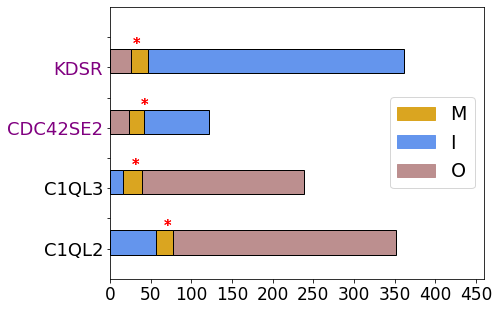

In [103]:
fig, ax = plt.subplots(1, figsize=(6.7, 5))

ax.set_ylim(0,4.5)
ax.set_yticks(np.arange(0.5, 4.5, 0.5))

lab = ['C1QL2', 'C1QL3', 'CDC42SE2', 'KDSR']

#lab =  ['C1QL2*',
# 'C1QL3*',
# 'SULT1A1',
# 'AC007906.1*',
# 'PDIA6',
# 'TRMT10C',
# 'SOX2*',
# 'LY6K*',
# 'CD59*',
# 'TIMP3',
# 'KDELR3',
# 'CD99']

l = [[x, ''] * 1 for x in lab]
flat_l = [item for sublist in l for item in sublist]
ax.set_yticklabels(flat_l,  fontsize=18)
    
#ax.set_yticklabels(list(coordinates.keys()))

ax.set_xlim(0, 460)
ax.set_xticks(np.arange(0, 460, 50))
ax.set_xticklabels(np.arange(0, 460, 50), fontsize=17)

for i, blocks in enumerate(coordinates.items()):
    gene = blocks[0].split('_')[0]
    cds_pos = int(blocks[0].split('_')[1])
    coo = blocks[1]

    for feat in coo:
        x1 = feat[1]
        x2 = feat[2]-feat[1]
        feat_type = feat[0]
        y1 = i + 0.4
        y2 = 0.4
        
        if (feat_type == 'M') | (feat_type == 'm'):
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'goldenrod'))
        elif (feat_type == 'o') | (feat_type == 'O') | (feat_type == 'S'):
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'rosybrown'))
        elif (feat_type == 'i') | (feat_type == 'I'):
            ax.add_patch(Rectangle((x1, y1), x2, y2, ec='black', facecolor = 'cornflowerblue'))
        else:
            continue
         
        plt.text(x=cds_pos, y=y1+0.40, s='*', color='red', size=15)


# legend 

colors = ['black', 'black', 'black', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple']

for ytick, color in zip(ax.get_yticklabels()[0:16], colors):
    ytick.set_color(color)
    

plt.rcParams["legend.fontsize"] = 19
M = mpatches.Patch(color='goldenrod', label='M')
I = mpatches.Patch(color='cornflowerblue', label='I')
O = mpatches.Patch(color='rosybrown', label='O')

plt.legend(handles=[M, I, O])

# RiboSET match 

In [73]:
li = []



for record in SeqIO.parse("localisation/TMHMM/Match_384_DeepTMHMM.3line", "fasta"):
    tr_id = record.id.split('_')[0]
    gene = record.id.split('_')[1]
    length = len(str(record.seq).split('*')[0])
    real_seq = str(record.seq).split('*')[0]
    pred_seq = str(record.seq).split('*')[1]
    real_len = len(real_seq)
    pred_len = len(pred_seq)
    
    if ('M' in list(pred_seq)):
        any_m = True 
        pos_of_1st_m = pred_seq.find('M')
    else:
        any_m = False 
        pos_of_1st_m = None
        
        
    li.append([tr_id, gene, length, real_seq, pred_seq,
                              real_len, pred_len, any_m, pos_of_1st_m])
    
    
    
parse_df = pd.DataFrame(li, columns = ['tr_id', 'gene', 'length', 'real_seq', 'prediction_seq',
                              'real_len', 'pred_len', 'any_m', 'pos_of_1st_m'])

parse_df[0:3]

,tr_id,gene,length,real_seq,prediction_seq,real_len,pred_len,any_m,pos_of_1st_m
0,ENST00000374644.8,EPHA8,519,SRRAGRSGQARGCVAPPPARPGPAMAPARGRLPPALWVVTAAAAAA...,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,519,520,False,NaN
1,ENST00000360295.13,SEZ6,1033,RLRPRSLYPAGPGSAPAPKPHQAPRPPAAVPAQGAAATSTMRPVAL...,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,1033,1034,True,967.0
2,ENST00000409204.4,PCDH20,980,SSPSDLHEPRGSVFCRPPFKSALTAASQGMRGRGNARSSQALGVSW...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,980,981,True,74.0


In [74]:
TMHMM_phyloset_preds = match_aa_df[['tr_id', 'gene', 'cds_start_aa_in_ext2']].merge(parse_df[parse_df['any_m'] == True], on=['gene'], how='inner').drop_duplicates()

TMHMM_phyloset_preds[TMHMM_phyloset_preds['pos_of_1st_m'] < TMHMM_phyloset_preds['cds_start_aa_in_ext2']].gene.unique()

array([], dtype=object)

In [ ]:
TP = {'RiboSET': 2, # 1
 'PhyloSET': 2, 
 'UntranslSET': 0,
 'RiboSET_ext': ?, 
}

# RiboSET_EXT

In [78]:
li = []

for record in SeqIO.parse("localisation/TMHMM/EXT_DeepTMHMM.3line", "fasta"):
    tr_id = record.id.split('_')[0]
    gene = record.id.split('_')[1]
    length = int(len(str(record.seq))/2)
    pred_seq = str(record.seq)[int(len(str(record.seq))/2):]
    real_seq = str(record.seq)[0:int(len(str(record.seq))/2)]
    real_len = len(real_seq)
    pred_len = len(pred_seq)
    
    if ('M' in list(pred_seq)):
        any_m = True 
        pos_of_1st_m = pred_seq.find('M')
    else:
        any_m = False 
        pos_of_1st_m = None
        
        
    li.append([tr_id, gene, length, real_seq, pred_seq,
                              real_len, pred_len, any_m, pos_of_1st_m])
    
    
    
parse_df = pd.DataFrame(li, columns = ['tr_id', 'gene', 'length', 'real_seq', 'prediction_seq',
                              'real_len', 'pred_len', 'any_m', 'pos_of_1st_m'])

parse_df[0:3]

,tr_id,gene,length,real_seq,prediction_seq,real_len,pred_len,any_m,pos_of_1st_m
0,ENST00000379454.8,ASPH,805,GTGSAAGAAARTRSSGPPPPAVPASRVYPRALKEVRQPSPAPADRA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,805,805,True,99.0
1,ENST00000216281.12,HSP90AA1,793,ARGRGGGWGGFFRKVREASGKSAARWAGPSLYKAGAGVARQLLQRP...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,793,793,False,NaN
2,ENST00000409753.7,HN1,202,RRRSAGQAAAAAPAAVVGCWVWSFPAPLGSDPLSVLLRRQPTSLLG...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,202,202,False,NaN


In [79]:
TMHMM_phyloset_preds = RiboSET_Ext[['tr_id', 'gene', 'cds_start_aa_in_ext2']].merge(parse_df[parse_df['any_m'] == True], on=['gene'], how='inner').drop_duplicates()

TMHMM_phyloset_preds[TMHMM_phyloset_preds['pos_of_1st_m'] < TMHMM_phyloset_preds['cds_start_aa_in_ext2']].gene.unique()

array(['CDC42SE2', 'KDSR', 'TMEM161B', 'PRRG4', 'ORMDL1', 'MFSD4B',
       'C1QL4', 'CERS6', 'C1QL3', 'GFRA2', 'C1QL2', 'PCDH10'],
      dtype=object)

In [80]:
TMHMM_phyloset_preds[TMHMM_phyloset_preds['pos_of_1st_m'] < TMHMM_phyloset_preds['cds_start_aa_in_ext2']].gene.nunique()

12

In [81]:
TMHMM_phyloset_preds[TMHMM_phyloset_preds['pos_of_1st_m'] < TMHMM_phyloset_preds['cds_start_aa_in_ext2']].to_csv('../Supplementary_tables/RiboSET_ext_DeepTMHMM.txt', sep='\t', index=False)

In [ ]:
TP = {'RiboSET': 2, # 1
 'PhyloSET': 2, 
 'UntranslSET': 0,
 'RiboSET_ext': 12, 
}

In [ ]:
# RiboSET ext vs matched 
a = 2
b = 390-2
c = 
d = 384-


table = [[a,b], 
         [c,d]]


oddsr, p = fisher_exact(table, alternative='greater')

p, oddsr

In [ ]:
# RiboSET ext vs matched 
a = 14
b = 3530-14
c = 
d = 384-


table = [[a,b], 
         [c,d]]


oddsr, p = fisher_exact(table, alternative='greater')

p, oddsr

# Phobius

# RiboSET

In [60]:
path = 'localisation/Phobius/RiboSET_Phobius.txt'

li1 = []

my_file = open(path, "r")
content = my_file.read()

li = content.split('ID   ')

for ids in li[1:]:
    el = ids.split('\n')
    tr_id = el[0].split('_')[0]
    gene = el[0].split('_')[-1]
    
    # iterate over features
    for feat in el[1:]:
        if feat.startswith('FT'):
            feat_li = list(filter(None, feat.split(' ')))
            feat_type = feat_li[1]
            start = int(feat_li[2])
            stop = int(feat_li[3])
            
            if len(feat_li) == 5:
                loc = feat_li[4]
            else:
                loc = None
            
            li1.append([tr_id, gene, feat_type, start, stop, loc])
            
phob_riboset_parse_df = pd.DataFrame(li1, columns = ['tr_id', 'gene', 'feat_type', 'start', 'stop', 'loc'])

phob_riboset_parse_df[0:1]

,tr_id,gene,feat_type,start,stop,loc
0,ENST00000379389.4,ISG15,TOPO_DOM,1,215,None


In [61]:
res = dict(tuple(phob_riboset_parse_df[(phob_riboset_parse_df['feat_type'] == 'TRANSMEM') & 
                            (~phob_riboset_parse_df['gene'].isin(['STIM2', 'AP3S1', 'PTPRJ']))].groupby('gene')))

selected_ribo_genes = []

for gene, df in res.items():
    df = df.sort_values(by='start', ascending=True)
    
    # select the 1st TM and its start
    first_tm = df.iloc[0].start 
    
    # cds_coo 
    cds_coo = NTE_aa_df_ribo[NTE_aa_df_ribo['gene'] == gene].iloc[0].cds_start_aa_in_ext2
    
    # 
    if first_tm < cds_coo:
        selected_ribo_genes.append(gene)
        
print (', '.join(selected_ribo_genes))

CD46, CD59, CDC42SE2, CTH, KDSR, LAMP2, LY6K, NIP7, OGT, PDIA6, SERTAD3, SOX2, TCF7L2, TNKS2, TRMT10C, ZNF316


In [62]:
len(selected_ribo_genes)

16

In [63]:
Pho = {'RiboSET': 16, # 1
 'PhyloSET': 0, 
 'RiboSET_ext': 0,
 'UntranslSET': 0,
 'UtranslSET_ext': 0,

}

# PhyloSET

In [64]:
path = 'localisation/Phobius/PhyloSET_Phobius.txt'

my_file = open(path, "r")
content = my_file.read()

li = content.split('ID   ')

li1 = []


for ids in li[1:]:
    el = ids.split('\n')
    tr_id = el[0].split('_')[0]
    gene = el[0].split('_')[-1]
    
    # iterate over features
    for feat in el[1:]:
        if feat.startswith('FT'):
            feat_li = list(filter(None, feat.split(' ')))
            feat_type = feat_li[1]
            start = int(feat_li[2])
            stop = int(feat_li[3])
            
            if len(feat_li) == 5:
                loc = feat_li[4]
            else:
                loc = None
            
            li1.append([tr_id, gene, feat_type, start, stop, loc])
            
phob_phyloset_parse_df = pd.DataFrame(li1, columns = ['tr_id', 'gene', 'feat_type', 'start', 'stop', 'loc'])

phob_phyloset_parse_df[0:5]

,tr_id,gene,feat_type,start,stop,loc
0,ENST00000377898.3,HES3,DOMAIN,1,207,None
1,ENST00000400907.6,RERE,DOMAIN,1,608,None
2,ENST00000455833.6,IFFO2,DOMAIN,1,635,None
3,ENST00000373824.8,TAF12,DOMAIN,1,193,None
4,ENST00000357214.5,SFPQ,DOMAIN,1,740,None


In [65]:
res = dict(tuple(phob_phyloset_parse_df[(phob_phyloset_parse_df['feat_type'] == 'TRANSMEM')].groupby('gene')))

selected_phylo_genes = []

for gene, df in res.items():
    df = df.sort_values(by='start', ascending=True)
    
    # select the 1st TM and its start
    first_tm = df.iloc[0].start 
    
    # cds_coo 
    cds_coo = NTE_aa_df[NTE_aa_df['gene'] == gene].iloc[0].cds_start_aa_in_ext2
    
    # 
    if first_tm < cds_coo:
        selected_phylo_genes.append(gene)
        
print (', '.join(selected_phylo_genes))

AC007906.1, C1QL2, C1QL3


In [ ]:
Pho = {'RiboSET': 16, # 1
 'PhyloSET': 3, 
 'RiboSET_ext': 0,
 'UntranslSET': 0,
}

# RiboSET-match 

In [70]:
path = 'localisation/Phobius/Match_384_Phobius.txt'

li1 = []

my_file = open(path, "r")
content = my_file.read()

li = content.split('ID   ')

for ids in li[1:]:
    el = ids.split('\n')
    tr_id = el[0].split('_')[0]
    gene = el[0].split('_')[-1]
    
    # iterate over features
    for feat in el[1:]:
        if feat.startswith('FT'):
            feat_li = list(filter(None, feat.split(' ')))
            feat_type = feat_li[1]
            start = int(feat_li[2])
            stop = int(feat_li[3])
            
            if len(feat_li) == 5:
                loc = feat_li[4]
            else:
                loc = None
            
            li1.append([tr_id, gene, feat_type, start, stop, loc])
            
phob_match390_parse_df = pd.DataFrame(li1, columns = ['tr_id', 'gene', 'feat_type', 'start', 'stop', 'loc'])

phob_match390_parse_df[0:1]

,tr_id,gene,feat_type,start,stop,loc
0,ENST00000374644.8,EPHA8,TOPO_DOM,1,204,CYTOPLASMIC.


In [71]:
res = dict(tuple(phob_match390_parse_df[(phob_match390_parse_df['feat_type'] == 'TRANSMEM')].groupby('gene')))

selected_match390_genes = []

for gene, df in res.items():
    df = df.sort_values(by='start', ascending=True)
    
    # select the 1st TM and its start
    first_tm = df.iloc[0].start 
    
    # cds_coo 
    try:
        cds_coo = match_aa_df[match_aa_df['gene'] == gene].iloc[0].cds_start_aa_in_ext2
    except:
        print ('???', gene)
    
    # 
    if first_tm < cds_coo:
        selected_match390_genes.append(gene)
        
print (', '.join(selected_match390_genes))

C1QTNF1, FXYD1, IL1RAP, LNX1, PDZK1IP1, PPP2R2B, RNF135, SLC12A4, SMIM24, UBE2Q2


In [72]:
len(set(selected_match390_genes))

10

In [ ]:
Pho = {'RiboSET': 16, # 1
 'PhyloSET': 3, 
 'RiboSET_ext': ?,
 'UntranslSET': 10
}

# RiboSET_EXT

In [80]:
path = 'localisation/Phobius/EXT_Phobius.txt'

li1 = []

my_file = open(path, "r")
content = my_file.read()

li = content.split('ID   ')

for ids in li[1:]:
    el = ids.split('\n')
    tr_id = el[0].split('_')[0]
    gene = el[0].split('_')[-1]
    
    # iterate over features
    for feat in el[1:]:
        if feat.startswith('FT'):
            feat_li = list(filter(None, feat.split(' ')))
            feat_type = feat_li[1]
            start = int(feat_li[2])
            stop = int(feat_li[3])
            
            if len(feat_li) == 5:
                loc = feat_li[4]
            else:
                loc = None
            
            li1.append([tr_id, gene, feat_type, start, stop, loc])
            
phob_riboset_ext_parse_df = pd.DataFrame(li1, columns = ['tr_id', 'gene', 'feat_type', 'start', 'stop', 'loc'])

phob_riboset_ext_parse_df[0:1]

,tr_id,gene,feat_type,start,stop,loc
0,ENST00000379454.8,ASPH,TOPO_DOM,1,99,CYTOPLASMIC.


In [81]:
res = dict(tuple(phob_riboset_ext_parse_df[(phob_riboset_ext_parse_df['feat_type'] == 'TRANSMEM')].groupby('gene')))

selected_riboset_ext_genes = []

for gene, df in res.items():
    df = df.sort_values(by='start', ascending=True)
    
    # select the 1st TM and its start
    first_tm = df.iloc[0].start 
    
    # cds_coo 
    try:
        cds_coo = RiboSET_Ext[RiboSET_Ext['gene'] == gene].iloc[0].cds_start_aa_in_ext2
    except:
        print ('???', gene)
    
    # 
    if first_tm < cds_coo:
        selected_riboset_ext_genes.append(gene)
        
print (', '.join(selected_riboset_ext_genes))

ABCA3, ABCA7, ABHD18, AC009336.19, ANGPT1, ANGPT2, APELA, APH1B, ARSK, C11orf87, C1QL2, C1QL3, C1QL4, CD46, CD59, CDC42SE2, CR2, CTH, DHRS3, EBAG9, EFNA3, EFNA5, EMILIN2, EOGT, F2RL3, FAM133B, FAM24B, FRRS1, GABRA5, GBA, GFRA2, GGH, GPANK1, GSTP1, GTF2B, HIST1H4E, HLA-DRA, HMSD, HOXD4, ID3, IFNGR1, IL13RA2, ITGB8, KDSR, KIAA0895, KIFC2, LAMP2, LRAT, LRFN4, LY6K, MAGEA1, MAGEA4, MAGEB1, MATN2, MEGF11, MFSD4B, MRPS35, MSANTD4, NDST3, NECAB3, NFXL1, NIP7, NKAIN3, NPR2, NRXN1, NRXN3, NUP155, OGT, P2RX4, PCDH10, PCNX1, PDE1B, PDIA6, PI16, PLXNA3, POLM, POSTN, RDH14, RMI1, RUNX2, S100A4, SENP2, SERPINB7, SERTAD3, SGSH, SIAE, SLC27A6, SLITRK4, SMG1, SOX2, SPN, STK11, SYCP2, TCF7L2, THBD, TIGD7, TMEM14A, TMEM161B, TMEM256-PLSCR3, TMEM63B, TMEM70, TNKS2, TRMT10C, TSPAN6, TXNDC16, UMAD1, UQCRFS1, UVSSA, VIT, ZMAT2, ZNF316, ZNF593


In [82]:
len(selected_riboset_ext_genes)

112

In [ ]:
Pho = {'RiboSET': 16, # 1
 'PhyloSET': 3, 
 'RiboSET_ext': 112,
 'UntranslSET': 10,
}

In [84]:
# RiboSET vs matched 
a = 16
b = 390-16
c = 10
d = 384-10


table = [[a,b], 
         [c,d]]


oddsr, p = fisher_exact(table, alternative='greater')

p, oddsr

(0.16932058351260637, 1.6)

In [85]:
# RiboSET vs matched 
a = 3
b = 390-3
c = 10
d = 384-10


table = [[a,b], 
         [c,d]]


oddsr, p = fisher_exact(table, alternative='greater')

p, oddsr

(0.9900665277348145, 0.289922480620155)

In [86]:
# RiboSET vs matched 
a = 112
b = 3451 - 112
c = 10
d = 384-10



table = [[a,b], 
         [c,d]]


oddsr, p = fisher_exact(table, alternative='greater')

p, oddsr

(0.3095110573109616, 1.2545073375262055)

In [66]:
RiboSET_EXT_cds_cov_nonzero.shape[0]

3451